# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows)

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_VERT,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
#print(feat_info.iloc[:,3])

In [11]:
azdias.shape

(891221, 85)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
print("Find missing-values and replace with NaN")
for index in feat_info.index:
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

Find missing-values and replace with NaN


In [13]:
azdias.shape

(891221, 85)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Columns with missing values:
Feature               Missing data   Percent
AGER_TYP                     685843    77.0
ALTERSKATEGORIE_GROB           2881    0.3
CJT_GESAMTTYP                  4854    0.5
GEBURTSJAHR                  392318    44.0
GFK_URLAUBERTYP                4854    0.5
HEALTH_TYP                   111196    12.5
LP_LEBENSPHASE_FEIN           97632    11.0
LP_LEBENSPHASE_GROB           94572    10.6
LP_FAMILIE_FEIN               77792    8.7
LP_FAMILIE_GROB               77792    8.7
LP_STATUS_FEIN                 4854    0.5
LP_STATUS_GROB                 4854    0.5
NATIONALITAET_KZ             108315    12.2
PRAEGENDE_JUGENDJAHRE        108164    12.1
RETOURTYP_BK_S                 4854    0.5
SHOPPER_TYP                  111196    12.5
SOHO_KZ                       73499    8.2
TITEL_KZ                     889061    99.8
VERS_TYP                     111196    12.5
ALTER_HH                     310267    34.8
ANZ_PERSONEN                  73499    8.2
ANZ_TITEL   

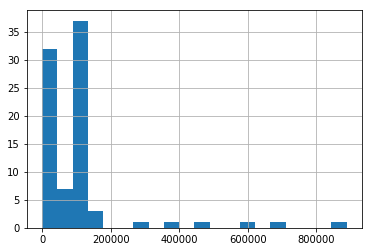

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
print("Columns with missing values:")

n_records = 891221
n_features = 85
missing_count = 0
missing = {}

print('Feature               Missing data   Percent')
for n in range(0, n_features):
    na = azdias.iloc[:,n].isnull().sum()
    if na !=0:
        missing_count += 1
        print('{:25s}  {:8d}    {:.1f}'.format(azdias.columns[n], na, na/n_records*100))
              
print("\nNumber of features with missing values: ", missing_count,"\n") 
na_pattern = azdias.isnull().sum().hist(bins=20)
plt.show()

In [15]:
azdias.shape

(891221, 85)

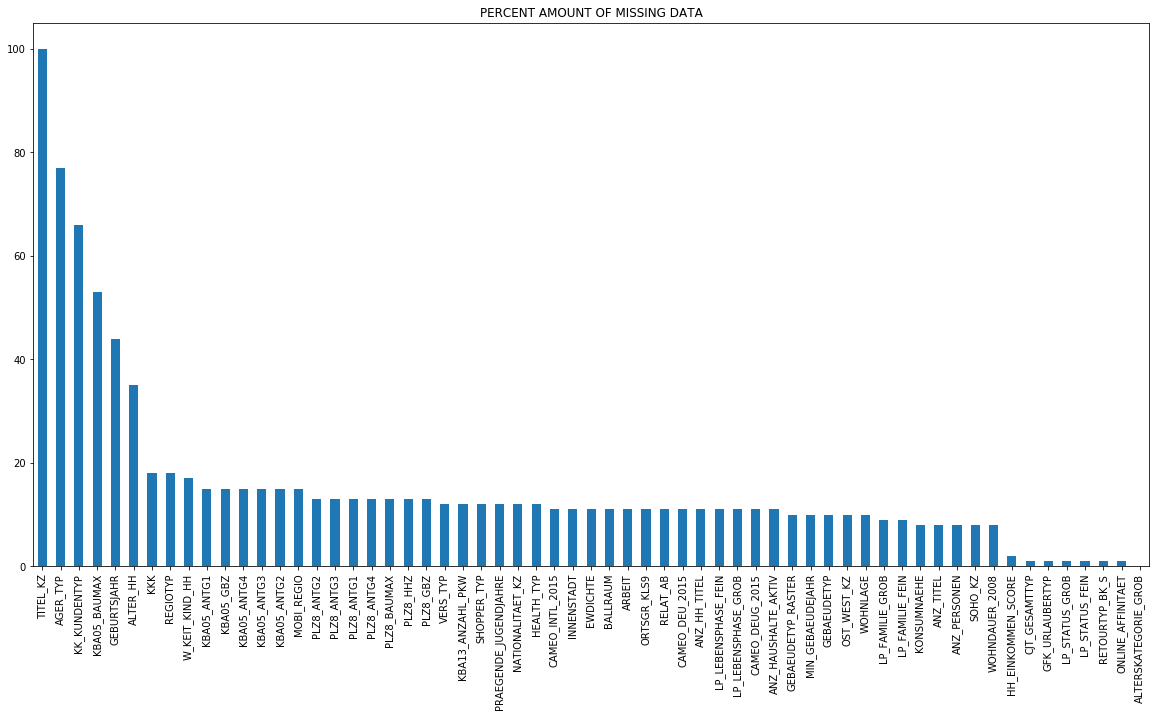

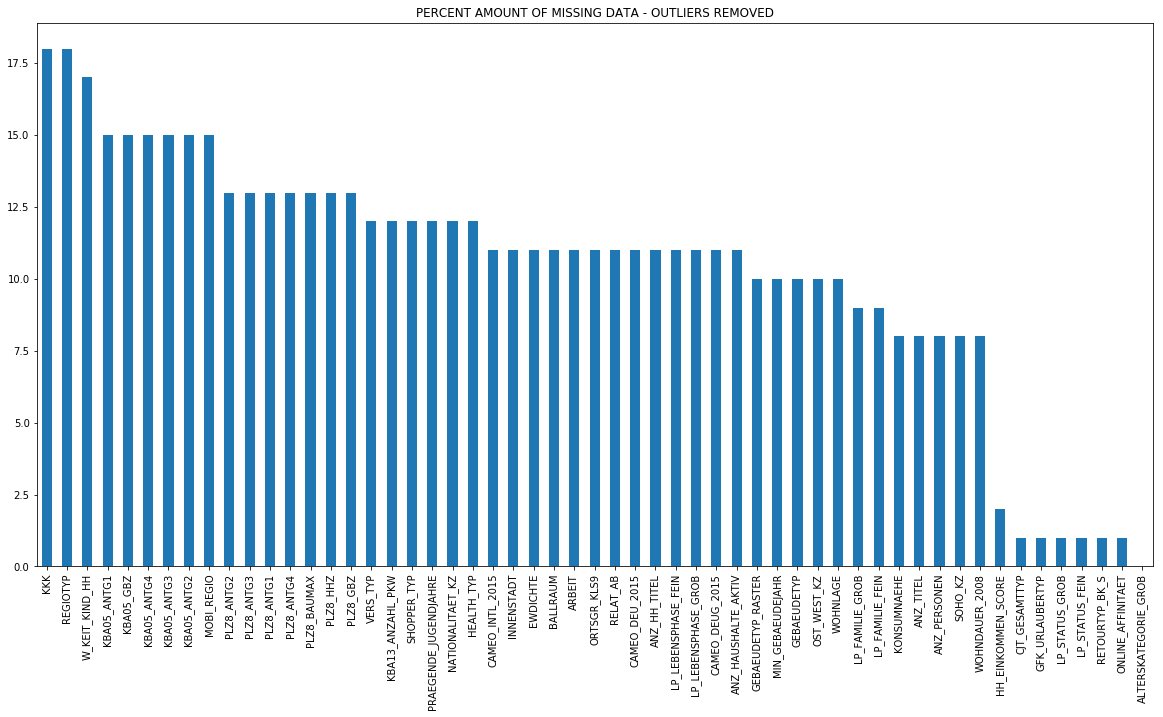

In [16]:
# Investigate patterns in the amount of missing data in each column.
#create subset of features/columns with missing values
na_cols = azdias.isna().sum()[azdias.isna().sum() > 0]

# Save percentages in a dictionary
na_dict = {'missing_%': np.round(na_cols*100/n_records)}

azdias_show_na = pd.DataFrame(data=na_dict, index=na_cols.index)
azdias_show_na.sort_values(by="missing_%", ascending= False, inplace=True)
#azdias_show_na.shape

#display
azdias_show_na.plot(kind='bar', title="PERCENT AMOUNT OF MISSING DATA", figsize=(20,10), legend=False)
#azdias_show_na.plot.bar(figsize=(20,10))

azdias_show_na.iloc[6:,:].plot(kind='bar', title="PERCENT AMOUNT OF MISSING DATA - OUTLIERS REMOVED", figsize=(20,10), legend=False)

In [17]:
azdias.shape

(891221, 85)

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outliers = list(azdias_show_na.iloc[:6,:].index)
print(outliers)
azdias.drop(outliers, axis='columns', inplace=True)

['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [19]:
#azdias_v1.shape
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are six features with more than 30 percent missing data:
  * TITEL_KZ (99.8%)
  * AGER_TYP (77.0%)
  * KBA05_BAUMAX (53.5%)
  * KK_KUNDENTYP (65.6%)
  * GEBURTSJAHR (44.0%)
  * ALTER_HH (34.8%)
  
  
  It seems that 30% of missing data is an appropriate criterion to define and remove outliers.  This is the criterion I used to remove the above columns from the data set.


Of the remaining 79 columns, 3 have more than 15 % missing data:  KKK and REGIOTYP are likely to be correlated.  The other, W_KEIT_KIND_HH, seems intended to predict family information, and thus could be useful if the latter is spotty.

The bulk of the remaining features (44) has between 8% and 15% of missing data.  

In summary, based on an analysis of the column data-:
  * 6 columns are unusable
  * 3 columns are marginal
  * 44 columns are good
  * 32 columns are complete or nearly so

Hence, 3/4 of the information is usable. Provided the data are reliable, this is pretty good.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

 mean of missing data in each row: 5.649893797385833
 median of missing data in each row: 0.0
 max of missing data in each row: 49
 min of missing data in each row: 0


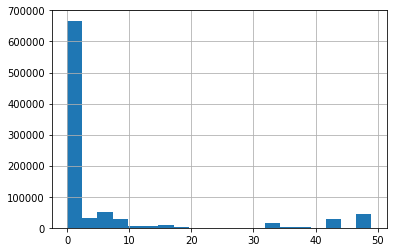

In [20]:
# How much data is missing in each row of the dataset?
#nan_rows = azdias.isna().sum(axis=1)
nan_rows = azdias.isna().sum(axis=1)
print(f" mean of missing data in each row: {nan_rows.mean()}")
print(f" median of missing data in each row: {nan_rows.median()}")
print(f" max of missing data in each row: {nan_rows.max()}")
print(f" min of missing data in each row: {nan_rows.min()}")
nan_rows.hist(bins=20)
plt.show()

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def nan_in_rows(k):
    azdias_more = azdias.loc[azdias.isna().sum(axis=1)>=k,:]
    print(f"number of rows with at least {k} % missing values: {azdias_more.shape[0]}")

    azdias_less = azdias.loc[azdias.isna().sum(axis=1)<k,:]
    print(f"number of rows with fewer than {k} % missing values: {azdias_less.shape[0]}")
    
    return azdias_more, azdias_less
    

number of rows with at least 6 % missing values: 171597
number of rows with fewer than 6 % missing values: 719624


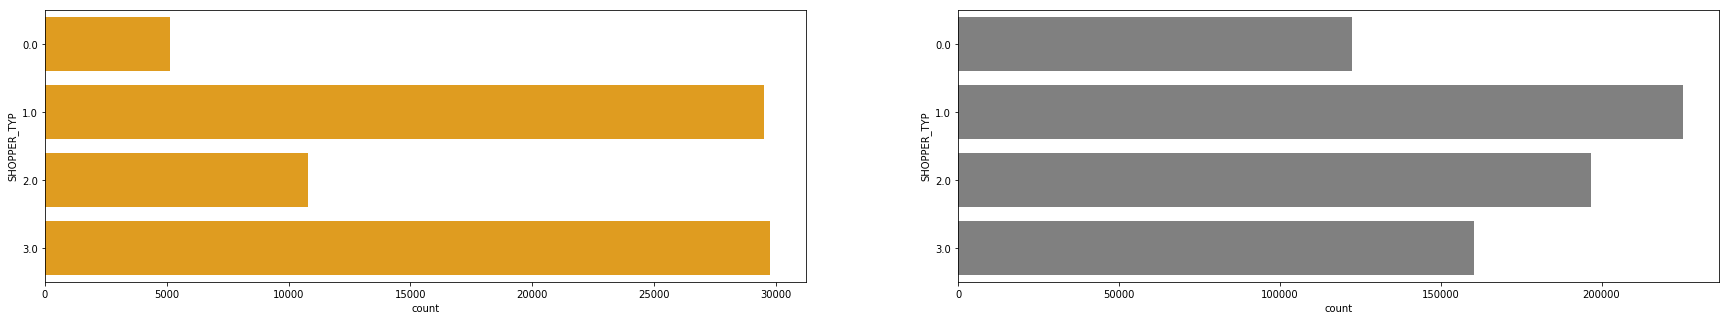

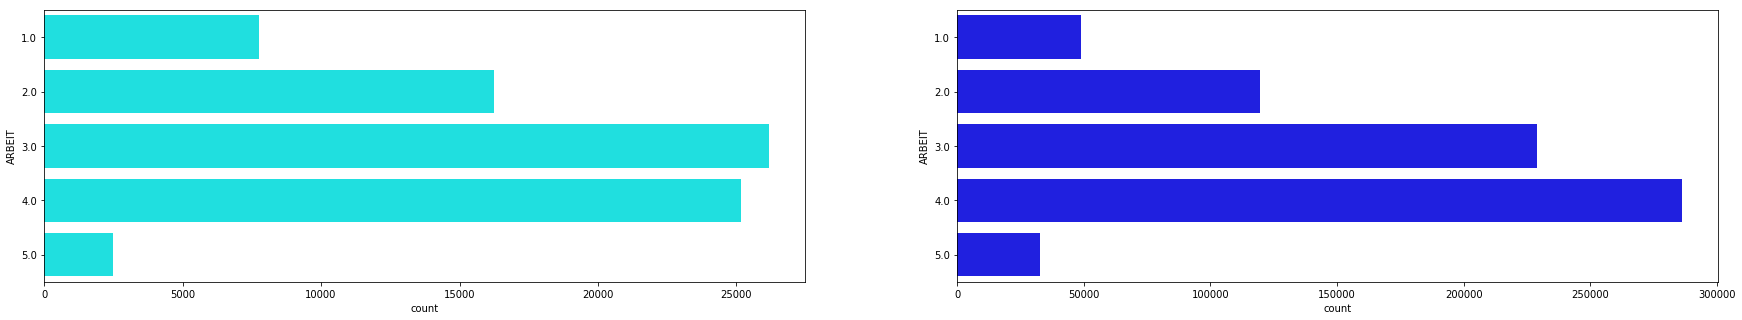

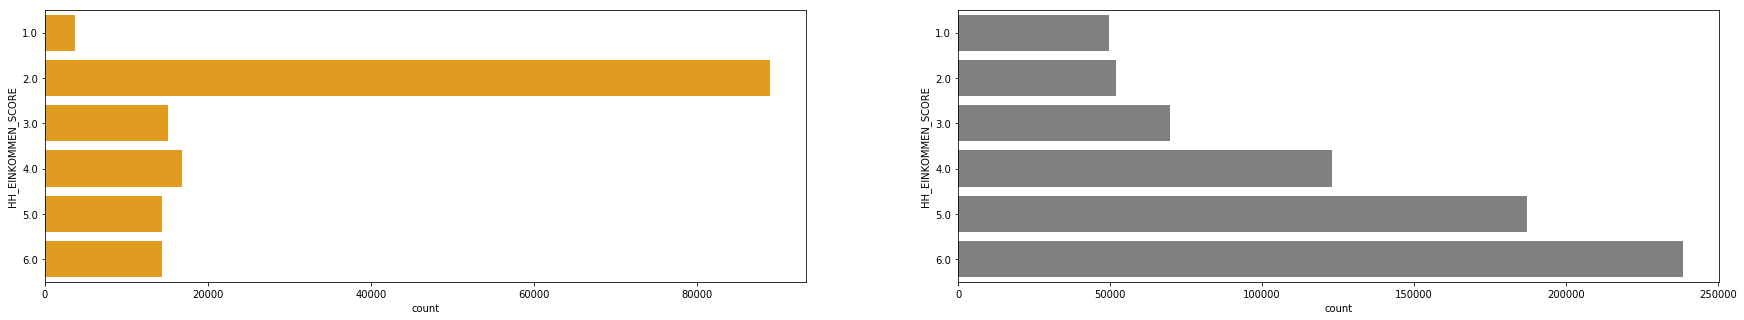

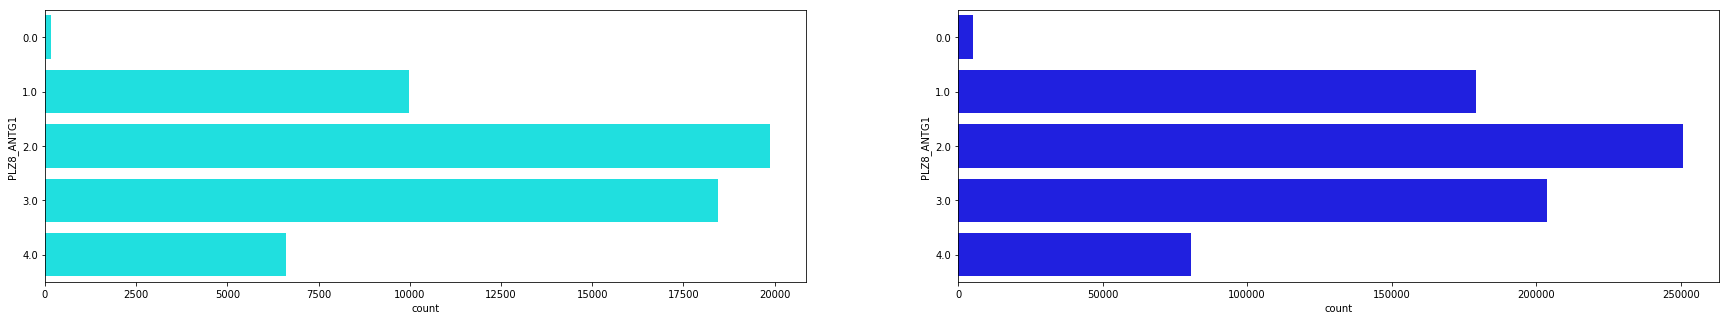

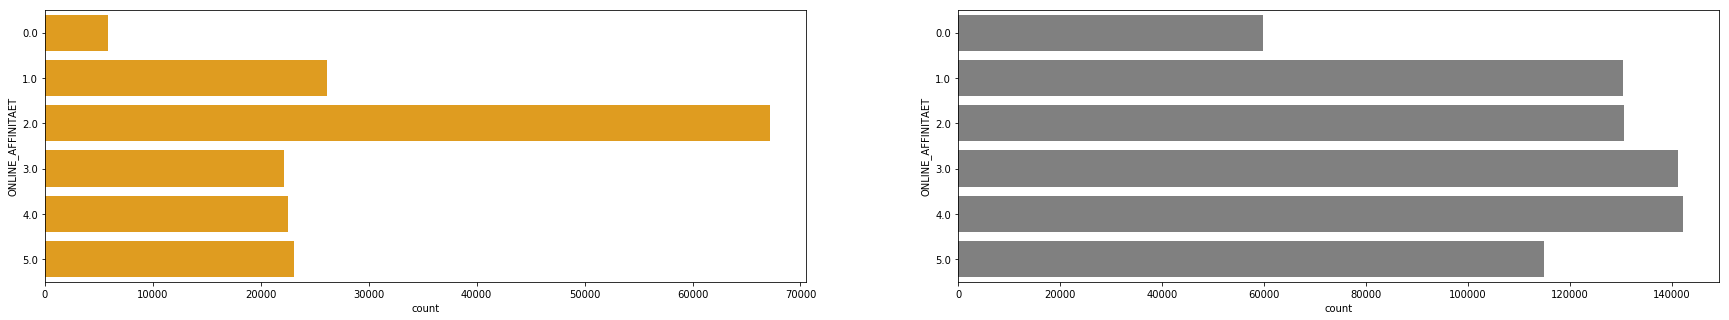

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_nan_in_rows(feat, c1, c2):
    
    plt.figure(figsize=(30,5))
    plt.subplot(121)
    sns.countplot(y=feat, data=azdias_more, color=c1)

    plt.subplot(122)
    sns.countplot(y=feat, data=azdias_less, color=c2)
    plt.show()

k = 6
azdias_more, azdias_less = nan_in_rows(k)

compare_nan_in_rows("SHOPPER_TYP", "orange", "grey")
compare_nan_in_rows("ARBEIT", "cyan", "blue")
compare_nan_in_rows("HH_EINKOMMEN_SCORE", "orange", "grey")
compare_nan_in_rows("PLZ8_ANTG1", "cyan", "blue")
compare_nan_in_rows("ONLINE_AFFINITAET", "orange", "grey")

#### Discussion 1.1.3: Assess Missing Data in Each Row

It is difficult to draw conclusions based on a comparison of only 5 features.  It seems that the distributions of missing values differ, depending on the column/feature under consideration.  Consider the examples below. 
  * "ARBEIT" and "PLZ8_ANTG1" (cyan/blue color combination) do not show significantly different distributions between the two subsets.  
  * "SHOPPER_TYP", "HH_EINKOMMEN_SCORE," and "ONLINE_AFFINITAET" (orange/grey color combination), conversely, show markedly different distributions.  
  
These five features illustrate different data categories:  location, income, personal characteristics. Hence, even this small and arbitrary sample shows that it is not possible to make general statements on the similarities or differences between the two subsets.

Consequently, I do not find a defensible reason for dropping rows without further investigation.  

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
feat_info.describe

<bound method NDFrame.describe of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical            [-1, 0]
1    ALTERSKATEGORIE_GROB            person      ordinal         [-1, 0, 9]
2               ANREDE_KZ            person  categorical            [-1, 0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numer

In [24]:
def find_variable_types (kind):
    type = feat_info.loc[feat_info['type'] == kind, 'attribute'].values
    print(f" number of {kind} variables: {type.shape[0]}")

find_variable_types('categorical')
find_variable_types('ordinal')
find_variable_types('numeric')
find_variable_types('interval')
find_variable_types('mixed')


 number of categorical variables: 21
 number of ordinal variables: 49
 number of numeric variables: 7
 number of interval variables: 1
 number of mixed variables: 7


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# categorical variables from feat_info 
all_cats = feat_info.loc[feat_info['type'] == 'categorical', "attribute"].values #list of categorical variables

#drop outliers from that list
temp = []
for out in outliers:
    k = 0
    for item in all_cats:
        if item == out:
            temp.append(k)
        k +=1
cats = np.delete(all_cats, temp)
print(cats.size)
print(all_cats.size)
print(outliers,"\n")
print(all_cats,"\n")
print(cats,"\n")

# get info on the categorical values
def get_cat_info(t):
    for item in t:
        temp = pd.get_dummies(azdias[item],columns=[item])
        print(item, temp.info(),"\n")

get_cat_info(cats)



18
21
['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'] 

['AGER_TYP' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'KK_KUNDENTYP' 'GEBAEUDETYP' 'OST_WEST_KZ'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015'] 

['ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'VERS_TYP'
 'ZABEOTYP' 'GEBAEUDETYP' 'OST_WEST_KZ' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 2 columns):
1    891221 non-null uint8
2    891221 non-null uint8
dtypes: uint8(2)
memory usage: 1.7 MB
ANREDE_KZ None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data colu

In [26]:
print(azdias.shape)

(891221, 79)


In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_go = azdias
# re-encode the only binary categorical variable with non-numeric values: OST_WEST_KZ
azdias_go['OST_WEST_KZ']= pd.get_dummies(azdias_go['OST_WEST_KZ'])
print("\n Dummied 'OST_WEST_KZ'", azdias.shape)

# re-encode the six multi-level categorical variables that we decided to retain (see discussion below):
cats_to_keep = ['CJT_GESAMTTYP','FINANZTYP','LP_FAMILIE_GROB','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP']
cats_to_drop = ['GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','GEBAEUDETYP', 'CAMEO_DEUG_2015','CAMEO_DEU_2015']

def transform_multi_level_cat(feat):
    cols = pd.get_dummies(azdias_go[feat], prefix=feat)
    return cols

# add new column to the data frame
for item in cats_to_keep:
    new_cols = transform_multi_level_cat(item)
    azdias_go = pd.concat([azdias_go, new_cols], axis=1)

print("Dummied 6 multi-level categorial variables",azdias_go.shape)   
azdias_go.drop(cats_to_keep, axis=1, inplace=True)
azdias_go.drop(cats_to_drop, axis=1, inplace=True)

print("Removed redundant and dropped columns ",azdias_go.shape)


 Dummied 'OST_WEST_KZ' (891221, 79)
Dummied 6 multi-level categorial variables (891221, 114)
Removed redundant and dropped columns  (891221, 101)


#### Discussion 1.2.1: Re-Encode Categorical Features

Recall the feature types:
  * 21 categorical variables
  * 49 ordinal variables
  * 7 numeric variables
  * 1 interval variables
  * 7 mixed variables

Ordinal, numeric and interval variables do not need further processing.

CATEGORICAL VARIABLES

Of the 21 categorical variables, three were removed as outliers.  This leaves us with 18 variables to deal with.
From the .info() method, I can separate the binary from the multilevel categorical variables.

**Binary:**
  * ANREDE_KZ
  * GREEN_AVANTGARDE
  * SOHO_KZ
  * VERS_TYP
  * OST_WEST_KZ


The last one in the above list is non-numerical and can be converted with get_dummies.  The rest does not need further treatment.

The non-binary categorical variables range from 3 to 44 levels. I first separated these variables into two groups: Those with more than 6 levels and those with 6 levels or fewer.  

**Six levels or fewer:**
  * CJT_GESAMTTYP (6)
  * FINANZTYP (6)
  * LP_FAMILIE_GROB (5)
  * LP_STATUS_GROB (5)
  * NATIONALITAET_KZ (3)
  * SHOPPER_TYP (4)
  * ZABEOTYP (6)
  
**More than six levels:**
  * GFK_URLAUBERTYP (12)
  * LP_FAMILIE_FEIN (11)
  * LP_STATUS_FEIN (10)
  * GEBAEUDETYP (8)
  * CAMEO_DEUG_2015 (9)
  * CAMEO_DEU_2015 (44)

LP_FAMILIE_FEIN is a more detailed version of LP_FAMILIE_GROB so it is defensible to drop the former while we retain the latter.  Ditto for LP_STATUS_FEIN and LP_STATUS_GROB. 

GFK_URLAUBERTYP provides detailed cultural information that may be relevant to some business and irrelevant to others. But I find the subcategories arbitrary and overlapping.  For example, a "hiker" is most likely also a "Nature Fan."  So, is this person a "5" or a "6"?  Similarly, a "Golden Ager" may be also a "Package Tour Traveler."  Hence, I have no qualms removing this attribute which may not bring clean information. 

GEBAEUDETYP actually looks like a bi-level variable and could be re-engineered as will be done for 'PRAEGENDE_JUGENDJAHRE' and CAMEO_INTL_2015.  But given that there is summary information of that nature in GEBAEUDETYP_RASTER (retained), I can remove GEBAEUDETYP.

CAMEO_DEU_2015 will be removed simply because it has too many levels (44); these extra columns might skew the analysis. CAMEO_DEUG_2015 seems to provide the same information as the mixed variable CAMEO_INTL_2015 but mapped differently.  Since we will deal with the latter subsequently, I can remove CAMEO_DEUG_2015.

In summary, we keep 12 of the 18 categorical variables and drop the rest.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# create two new columns
PR_J_mvt = pd.Series(azdias_go['PRAEGENDE_JUGENDJAHRE'], name='PR_J_mvt')
PR_J_gen = pd.Series(azdias_go['PRAEGENDE_JUGENDJAHRE'], name='PR_J_gen')

# replace codes
PR_J_mvt = PR_J_mvt.replace([1, 3, 5, 8, 10, 12, 14], 0)
PR_J_mvt = PR_J_mvt.replace ([2, 4, 6, 7, 9, 11, 13, 15], 1)

PR_J_gen = PR_J_gen.replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
                 [1, 1, 2, 2, 3, 3, 3, 4, 4, 6, 6, 6, 6, 7, 7])

azdias_go = pd.concat([azdias_go, PR_J_mvt, PR_J_gen ], axis = 1)
print("Replaced 'PRAEGENDE_JUGENDJAHRE' with two new variables: ", azdias_go.shape)
          
#drop "PRAEGENDE_JUGENDJAHRE
azdias_go = azdias_go.drop("PRAEGENDE_JUGENDJAHRE", axis=1)
print("Dropped 'PRAEGENDE_JUGENDJAHRE': ", azdias_go.shape)
print("\n", azdias_go.columns)

Replaced 'PRAEGENDE_JUGENDJAHRE' with two new variables:  (891221, 103)
Dropped 'PRAEGENDE_JUGENDJAHRE':  (891221, 102)

 Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'SHOPPER_TYP_2.0', 'SHOPPER_TYP_3.0', 'ZABEOTYP_1', 'ZABEOTYP_2',
       'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5', 'ZABEOTYP_6', 'PR_J_mvt',
       'PR_J_gen'],
      dtype='object', length=102)


In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# create two new columns
CAMEO_wealth = pd.Series(azdias_go['CAMEO_INTL_2015'], name= 'CAMEO_wealth')
CAMEO_life = pd.Series(azdias_go['CAMEO_INTL_2015'], name= 'CAMEO_life')

# replace codes
wealth = [['11', '12', '13', '14', '15'], 
          ['21', '22', '23', '24', '25'],
          ['31', '32', '33', '34', '35'], 
          ['41', '42', '43', '44', '45'],
          ['51', '52', '53', '54', '55']] 

life = [['11', '21', '31', '41', '51'],
       ['12', '22', '32', '42', '52'], 
       ['13', '23', '33', '43', '53'],
       ['14', '24', '34', '44', '54'],
       ['15', '25', '35', '45', '55']]

def replace_codes(s,item, k):
    s = s.replace(item, k)
    return s

k = 5
for item in wealth:
    CAMEO_wealth = replace_codes(CAMEO_wealth, item, k)
    k = k - 1

k = 1
for item in life:
    CAMEO_life = replace_codes(CAMEO_life, item, k)
    k +=1

azdias_go = pd.concat([azdias_go, CAMEO_wealth, CAMEO_life], axis = 1)
print("Replaced 'CAMEO_INTL_2015' with two new variables: ", azdias_go.shape)          
#drop "CAMEO_INTL_2015"
azdias_go = azdias_go.drop("CAMEO_INTL_2015", axis=1) 
print("Dropped 'CAMEO_INTL_2015': ", azdias_go.shape)
print("\n", azdias_go.columns)

Replaced 'CAMEO_INTL_2015' with two new variables:  (891221, 104)
Dropped 'CAMEO_INTL_2015':  (891221, 103)

 Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'ZABEOTYP_1', 'ZABEOTYP_2', 'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5',
       'ZABEOTYP_6', 'PR_J_mvt', 'PR_J_gen', 'CAMEO_wealth', 'CAMEO_life'],
      dtype='object', length=103)


#### Discussion 1.2.2: Engineer Mixed-Type Features
**"PRAEGENDE_JUGENDJAHRE"**

The "Mainstream" label corresoponds to codes (1, 3, 5, 8, 10, 12, 14).  
The "Avant-Garde" label corresponds to codes (2, 4, 6, 7, 9, 11, 13, 15).

- Step 1:

  * Copy "PRAEGENDE_JUGENDJAHRE" to a new column: "PR_J_mvt"
  * Replace (1, 3, 5, 8, 10, 12, 14) with (0) i.e., mainstream indicator
  * Replace ((2, 4, 6, 7, 9, 11, 13, 15) with (1) i.e., avant-garde indicator
  * Copy "PRAEGENDE_JUGENDJAHRE" to a new column "PR_J_gen" 
  * Replace each group of two successsive codes with a single age indicator, e.g., :
      * (1, 2) --> 1, 1
      * (3, 4) --> 2, 2
- Step 2:
  * Append 'PR_J_Movement" column to capture Mainstream vs. Avant-Garde
  * Append "PR_J_Gen" column to capture decade


- Step 3: Remove "PRAEGENDE_JUGENDJAHRE"

NOTES: 
  * 0 was an "unknown" indicator, but has been changed earlier to NaN, so now we have a binary numeric column.
  * there are 4 codes for the 80 decade and 3 for the 60 decade.


**"CAMEO_INTL_2015"**
I follow the same process for "CAMEO_INTL_2015".

There are five levels for wealth (the first digit) and five levels for the life stage (the second digit), namely:

   - Wealthy: 11-15
   - Prosperous: 21-25
   - Comfortable: 31-35
   - Less affluent: 41-45
   - Poorer: 51-55


   - Pre-Family Couples & Singles (11, 21, 31, 41, 51)
   - Young Couples With Children (12, 22, 32, 42, 52)
   - Families With School Age Children (13, 23, 33, 43, 53)
   - Older Families & Mature Couples (14, 24, 34, 44, 54)
   - Elders In Retirement (15, 25, 35, 45, 55)


- Step 1:

  * Copy "CAMEO_INTL_2015" to a new column: "CAMEO_wealth"
  * Replace (11-55) with the appropriate weath indicator (a number between 1 and 5 (1=poorer, 5=wealthy)
  * Copy "CAMEO_INTL_2015" to a new column "CAMEO_life" 
  * Replace (11-55) with the appropriate life-stage indicator (a number between 1 and 5 (1=younger, 5=older)
  
- Step 2:
  * Append "CAMEO_wealth" column to capture the wealth level
  * Append "CAMDEO_life" column to capture life stage

- Step 3: Remove "CAMEO_INTL_2015"


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print("\n Array size for cleaned data base (azdias_go): ", azdias_go.shape)

# check:

print("\n . 85 columns initially" ,
      "\n . (6) outliers removed",
     "\n . 35 columns added to replace 7 multi-level categorical features",
     "\n . (7) columns dropped after above replacement",
     "\n . (6) categorical features dropped without replacement",
      "\n . 2 columns added to replace PRAEGENDE_JUGENDJAHRE",
     "\n . 2 columns added to replace CAMEO_INTL_2015",
     "\n . (2) columns (PRAEGENDE_JUGENDJAHRE & CAMEO_INTL_2015) dropped after replacement",
     "\n Hence:  85 + [39] - [21] = 103",
     "\n No change in rows",
     "\n\n Looks right")


 Array size for cleaned data base (azdias_go):  (891221, 103)

 . 85 columns initially 
 . (6) outliers removed 
 . 35 columns added to replace 7 multi-level categorical features 
 . (7) columns dropped after above replacement 
 . (6) categorical features dropped without replacement 
 . 2 columns added to replace PRAEGENDE_JUGENDJAHRE 
 . 2 columns added to replace CAMEO_INTL_2015 
 . (2) columns (PRAEGENDE_JUGENDJAHRE & CAMEO_INTL_2015) dropped after replacement 
 Hence:  85 + [39] - [21] = 103 
 No change in rows 

 Looks right


In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df, outliers, cats_to_keep, cats_to_drop, wealth, life):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Convert missing codes to NaNs:
    for index in feat_info.index:
        feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
        for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
            try:
                feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
            except:
                continue
        df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)
    
    # remove selected columns and row
    
    ## Remove the six outlier columns
    df.drop(outliers, axis='columns', inplace=True)
    print("Outliers dropped: ", df.shape)

    ## Check NaNs in columns:
    na_in_cols = df.isnull().sum().hist(bins=20)
    plt.show()
    
    ## Check NaNs in rows:
    na_in_rows = df.isnull().sum(axis=1).hist(bins=20)
    plt.show()
    
    # select, re-encode, and engineer column values.
    ## re-incode 'OST_WEST_KZ' (binary with non-numeric values)
    df['OST_WEST_KZ'] = pd.get_dummies(df['OST_WEST_KZ'])
    
    print("Dummied 'OST_WEST_KZ': ", df.shape)
    
    # add new column to the data frame
    for item in cats_to_keep:
        new_cols = pd.get_dummies(df[item], prefix=item)
        df = pd.concat([df, new_cols], axis=1)

    print("Dummied 6 multi-level categorial variables: ", df.shape)   
    # drop the old categorical columns
    df.drop(cats_to_keep, axis=1, inplace=True)
    df.drop(cats_to_drop, axis=1, inplace=True)
    print("Removed redundant and dropped columns: ", df.shape)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # create two new columns
    PR_J_mvt = pd.Series(df['PRAEGENDE_JUGENDJAHRE'], name='PR_J_mvt')
    PR_J_gen = pd.Series(df['PRAEGENDE_JUGENDJAHRE'], name='PR_J_gen')

    # replace codes
    PR_J_mvt = PR_J_mvt.replace([1, 3, 5, 8, 10, 12, 14], 0)
    PR_J_mvt = PR_J_mvt.replace ([2, 4, 6, 7, 9, 11, 13, 15], 1)

    PR_J_gen = PR_J_gen.replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
                 [1, 1, 2, 2, 3, 3, 3, 4, 4, 6, 6, 6, 6, 7, 7])

    df = pd.concat([df, PR_J_mvt, PR_J_gen ], axis = 1)     
    #drop "PRAEGENDE_JUGENDJAHRE
    df = df.drop("PRAEGENDE_JUGENDJAHRE", axis=1)
    print("Replaced and dropped 'PRAEGENDE_JUGENDJAHRE': ", df.shape)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # create two new columns
    CAMEO_wealth = pd.Series(df['CAMEO_INTL_2015'], name= 'CAMEO_wealth')
    CAMEO_life = pd.Series(df['CAMEO_INTL_2015'], name= 'CAMEO_life')

    # replace codes
    k = 5
    for item in wealth:
        CAMEO_wealth = replace_codes(CAMEO_wealth, item, k)
        k = k - 1

    k = 1
    for item in life:
        CAMEO_life = replace_codes(CAMEO_life, item, k)
        k +=1

    df = pd.concat([df, CAMEO_wealth, CAMEO_life], axis = 1)
          
    #drop "CAMEO_INTL_2015"
    df = df.drop("CAMEO_INTL_2015", axis=1) 
    print("Replaced and dropped 'CAMEO_INTL_2015' : ", df.shape)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

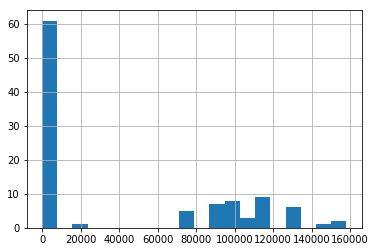

In [33]:
# summary
azdias_go.describe()

# show the distribution of NaNs
na_pattern = azdias_go.isna().sum().hist(bins=20)
plt.show()

In [34]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imp = Imputer(strategy='most_frequent')
azdias_imp = imp.fit_transform(azdias_go)

In [35]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imp) 


In [36]:
df = pd.DataFrame(azdias_scaled)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 103 entries, 0 to 102
dtypes: float64(103)
memory usage: 700.3 MB


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.

def pca_results(pca, k):
    # NOTE: This method was obtained from Udacity's course notes/lab work
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the results
    '''
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_go.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    if k !=0:
        # Create a bar plot visualization
        fig, ax = plt.subplots(figsize = (20,8))

        # Plot the feature weights as a function of the components
        components.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dimensions, rotation=90)
        ax.text(0, ax.get_ylim()[1]+ 0.2, "EXPLAINED VARIANCE")

        # Display the explained variance ratios
        for i, ev in enumerate(pca.explained_variance_ratio_):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.1, "       %.4f"%(ev), rotation=90)
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

for n in range(40, 61, 10):
    pca = PCA(n)
    X_pca = pca.fit_transform(azdias_scaled)
    comp_check = pca_results(pca, 0)
  
    print("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0], comp_check['Explained Variance'].sum())) 

Using 40 components, we can explain 0.8258999999999999% of the variability in the original data.
Using 50 components, we can explain 0.8920000000000001% of the variability in the original data.
Using 60 components, we can explain 0.9340999999999999% of the variability in the original data.


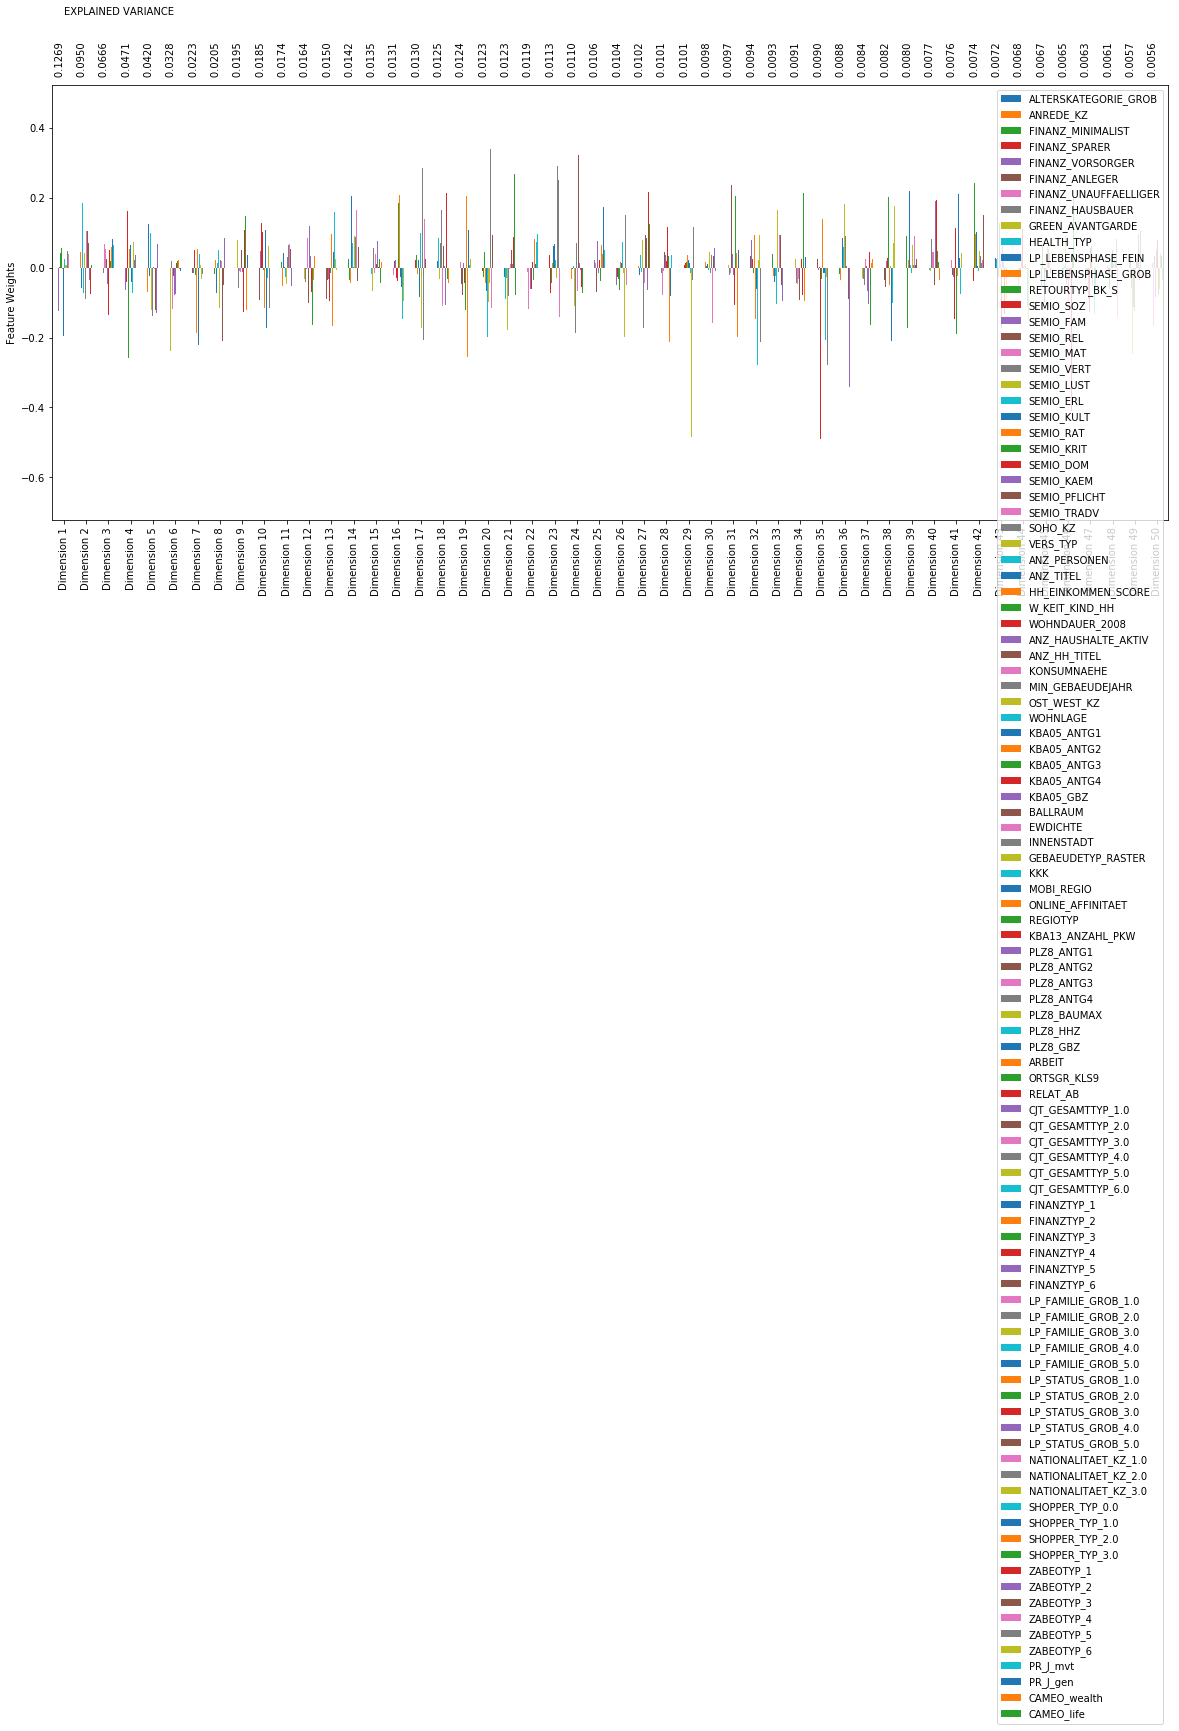

In [38]:
# Investigate the variance accounted for by each principal component.
# go for 50 components

n_components = 50
pca = PCA(n_components)
X_pca = pca.fit_transform(azdias_scaled)
comp_check = pca_results(pca, 1)

#num_comps = comp_check.shape[0] 

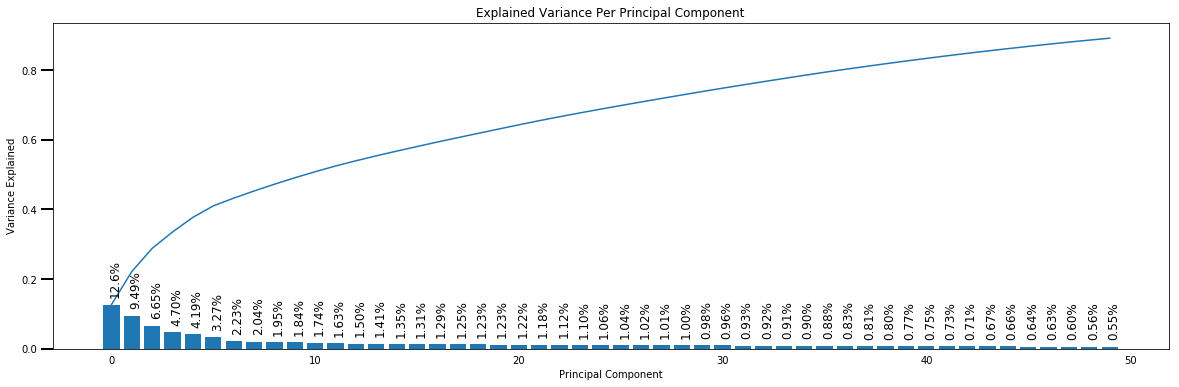

In [39]:
# try a scree plot
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]+0.02), va="bottom", ha="center", fontsize=12, rotation=90)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)    

In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Done above


In [41]:
print(comp_check.shape)

(50, 104)


### Discussion 2.2: Perform Dimensionality Reduction

I ran the PCA analysis for 40, 50, and 60 components, which explained 82.6%, 89.2% and 93.4% of the variability in the original data, respectively.  I settled for 50 components, which reduces the dimensionality by half (from 103 to 50), considering that a gain of 4.2% in accuracy did not seem to justify the lesser dimensionality reduction--and thus the higher complexity--of working with 60 components .

With 50 pca components, the first 8 components explain 45% of the total variability, as seen on the charts above.  

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.


Weights for Principal Component 1
Positive 
PLZ8_ANTG3            0.1894
LP_STATUS_GROB_1.0    0.1782
EWDICHTE              0.1686
FINANZ_SPARER         0.1611
PLZ8_BAUMAX           0.1559
ORTSGR_KLS9           0.1557
PLZ8_ANTG4            0.1496
FINANZ_HAUSBAUER      0.1365
HH_EINKOMMEN_SCORE    0.1358
PLZ8_ANTG2            0.1304
Name: Dimension 1, dtype: float64 

Negative 
FINANZ_MINIMALIST     -0.2093
MOBI_REGIO            -0.1963
KBA05_ANTG1           -0.1892
PLZ8_ANTG1            -0.1871
CAMEO_wealth          -0.1809
KBA05_GBZ             -0.1808
KONSUMNAEHE           -0.1502
LP_LEBENSPHASE_FEIN   -0.1495
PLZ8_GBZ              -0.1373
LP_LEBENSPHASE_GROB   -0.1338
Name: Dimension 1, dtype: float64 



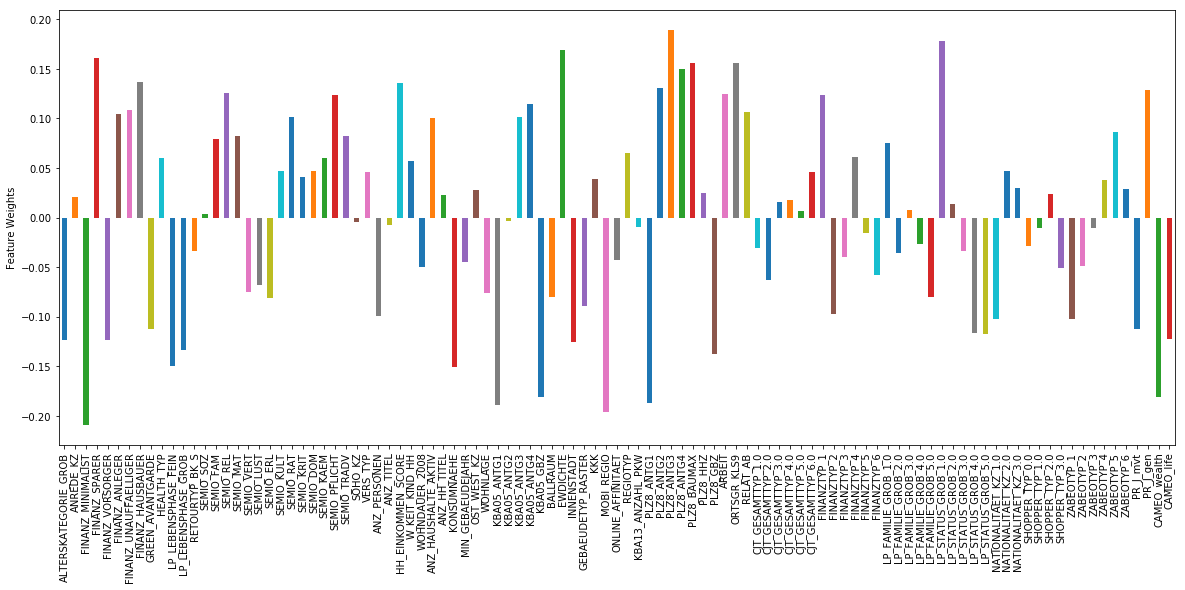

In [42]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
 
# sort weights
def compare_comp(n):
    weights_sorted_a = comp_check.iloc[n,1:].sort_values().head(10)
    weights_sorted_d = comp_check.iloc[n,1:].sort_values(ascending=False).head(10)
    print(f"\nWeights for Principal Component {n+1}")
    print(f"Positive \n{weights_sorted_d} \n")
    print(f"Negative \n{weights_sorted_a} \n")

def map_pca(n, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_go.keys())
    components.index = dimensions
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (20,8))

    # Plot the feature weights as a function of the components
    components.iloc[n,:].plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(azdias_go.keys(), rotation=90)

map_pca(0, pca)
compare_comp(0)


Weights for Principal Component 2
Positive 
ALTERSKATEGORIE_GROB    0.2231
FINANZ_VORSORGER        0.2125
SEMIO_ERL               0.1844
ZABEOTYP_3              0.1700
RETOURTYP_BK_S          0.1571
SEMIO_LUST              0.1520
FINANZ_HAUSBAUER        0.1262
PLZ8_ANTG4              0.1199
PLZ8_BAUMAX             0.1137
W_KEIT_KIND_HH          0.1122
Name: Dimension 2, dtype: float64 

Negative 
PR_J_gen                -0.2274
FINANZ_SPARER           -0.2148
FINANZ_UNAUFFAELLIGER   -0.2118
SEMIO_REL               -0.2088
SEMIO_PFLICHT           -0.2011
FINANZ_ANLEGER          -0.2007
SEMIO_TRADV             -0.1962
ONLINE_AFFINITAET       -0.1681
SEMIO_RAT               -0.1609
SEMIO_KULT              -0.1516
Name: Dimension 2, dtype: float64 



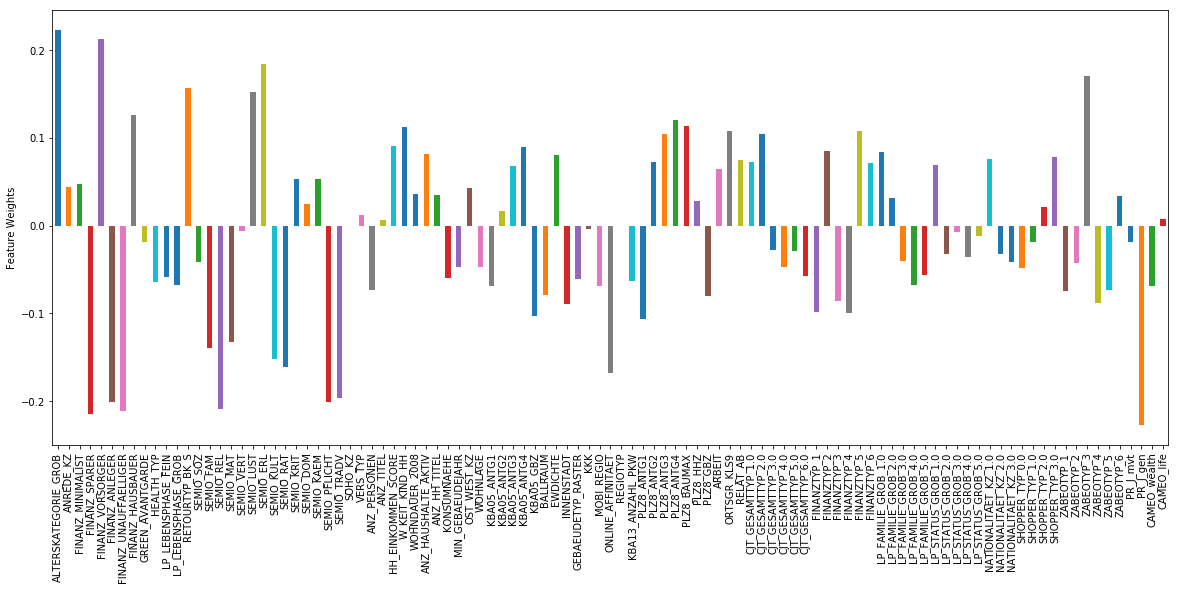

In [43]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca(1, pca)
compare_comp(1)


Weights for Principal Component 3
Positive 
SEMIO_VERT              0.3162
SEMIO_SOZ               0.2783
SEMIO_KULT              0.2714
SEMIO_FAM               0.1824
SHOPPER_TYP_0.0         0.1324
PLZ8_ANTG4              0.1302
PLZ8_BAUMAX             0.1191
FINANZTYP_5             0.1171
ZABEOTYP_1              0.1084
NATIONALITAET_KZ_1.0    0.1045
Name: Dimension 3, dtype: float64 

Negative 
SEMIO_KAEM         -0.3017
SEMIO_KRIT         -0.2941
ANREDE_KZ          -0.2814
SEMIO_DOM          -0.2735
SEMIO_ERL          -0.1556
FINANZ_ANLEGER     -0.1519
ZABEOTYP_3         -0.1363
KBA13_ANZAHL_PKW   -0.1347
FINANZTYP_4        -0.1333
BALLRAUM           -0.1057
Name: Dimension 3, dtype: float64 



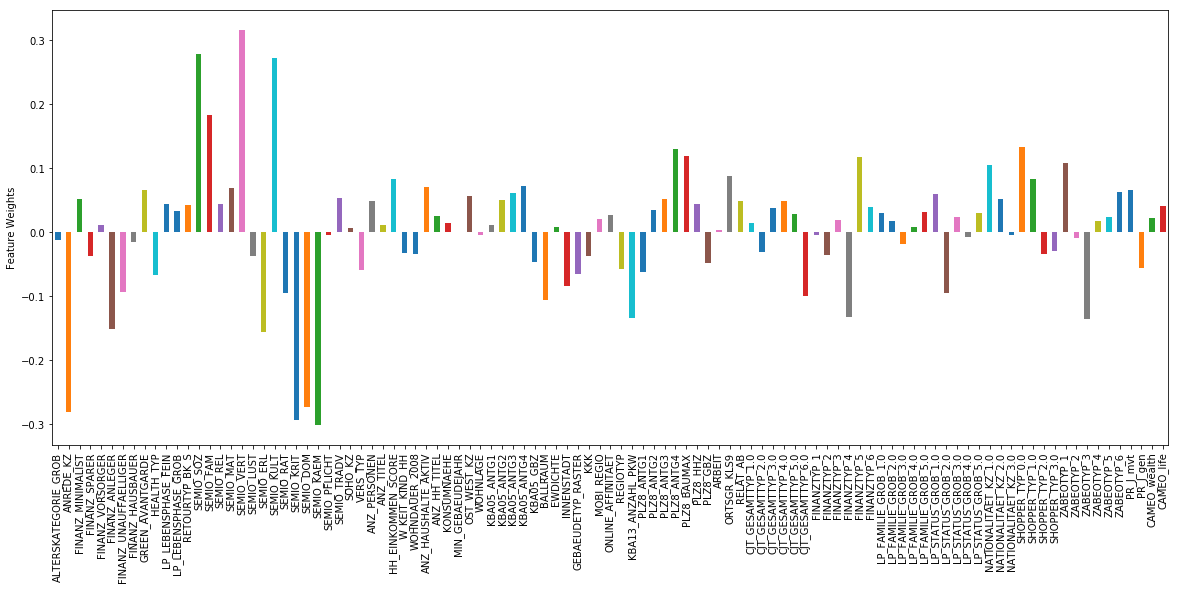

In [44]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca(2, pca)
compare_comp(2)

### Discussion 2.3: Interpret Principal Components

**Principal Component 1**

The first principal component emphasizes the "housing" features, and specifically the residential real-estate in the area. Four of the ten highest positive weights in that component are of the form PLZ8_ANTG* where the PLZ8 prefix relates to a district/Zip code and the ANTG suffix indicates the density of individual houses in the area.  Consistent with the emphasis on home ownership are the FINANZ_HAUSBAUER and HH_EINKOMMEN_SCORE variables listed among the top ten.  

  - **PLZ8_ANTG3 -- 0.1894**
  - LP_STATUS_GROB_1.0 -- 0.1782
  - EWDICHTE -- 0.1686
  - FINANZ_SPARER -- 0.1611
  - **PLZ8_BAUMAX -- 0.1559**
  - ORTSGR_KLS9 -- 0.1557
  - **PLZ8_ANTG4 -- 0.1496**
  - FINANZ_HAUSBAUER -- 0.1365
  - HH_EINKOMMEN_SCORE -- 0.1358
  - **PLZ8_ANTG2 -- 0.1304**
  
Also consistent with the residential real-estate story are some of the variable weighted negatively.  PLZ8_ GBZ refers to commercial buildings and FINANZ_MINIMALIST would indicate an individual with little interest in financial matters--and by extension in home ownership.  Also noteworthy is PLZ8_ANTG1, which refers to the lowest density of individual housing in the area.


  - **FINANZ_MINIMALIST --     (0.2093)**
  - MOBI_REGIO   --         (0.1963)
  - KBA05_ANTG1  --         (0.1892)
  - **PLZ8_ANTG1 --           (0.1871)**
  - CAMEO_wealth --         (0.1809)
  - KBA05_GBZ --            (0.1808)
  - KONSUMNAEHE --          (0.1502)
  - LP_LEBENSPHASE_FEIN --  (0.1495)
  - **PLZ8_GBZ  --           (0.1373)**
  - LP_LEBENSPHASE_GROB --  (0.1338)


**Principal Component 2**

In the second principal component, three of the attributes that were are the top of Principal Component 1 also appear here: PLZ8_ANTG4, PLZ8_BAUMAX, FINANZ_HAUSBAUER, which continues the emphasis on residential private housing and home ownership.  The financial variables also appear prominently, both with positive and negative weights.  Interestingly, FINANZ_SPARER, which had a positive weight in Principal Component 1 is weighed negatively in Principal Component 2 (?). 

What is new is the apparition of "soft" attributes that refer to personal and behavioral characteristics, i.e., those attributes with the SEMIO_ prefix, as well RETOURTYP_BK_S and ONLINE_AFFINITAET which describe shopping habits.
 
  - ALTERSKATEGORIE_GROB --   0.2231
  - FINANZ_VORSORGER   --     0.2125
  - **SEMIO_ERL     --          0.1844**
  - ZABEOTYP_3 --             0.1700
  - RETOURTYP_BK_S  --        0.1571
  - **SEMIO_LUST --             0.1520**
  - **FINANZ_HAUSBAUER  --      0.1262**
  - **PLZ8_ANTG4  --            0.1199**
  - **PLZ8_BAUMAX  --           0.1137**
  - W_KEIT_KIND_HH  --        0.1122


Among the negative weights, five of the ten largest absolute values concern personality characteristics SEMIO_* of some form of anoother.  The finance attribute FINANZ_UNAUFFAELLIGER parallels FINANZ_MINIMALIST in the first principal component.  The other two finance attributes in the negative section--FINANZ_SPARER and FINANZ_ANLEGER--are hard to explain because they represent, in my opinion, opposite characteristic--money saver and investor.

  - PR_J_gen        --        (0.2274)
  - FINANZ_SPARER    --       (0.2148)
  - FINANZ_UNAUFFAELLIGER --  (0.2118)
  - **SEMIO_REL         --      (0.2088)**
  - **SEMIO_PFLICHT   --        (0.2011)**
  - FINANZ_ANLEGER  --        (0.2007)
  - **SEMIO_TRADV     --        (0.1962)**
  - ONLINE_AFFINITAET --      (0.1681)
  - **SEMIO_RAT    --           (0.1609)**
  - **SEMIO_KULT   --           (0.1516)**


**Principal Component 3**

The third principal component continues to rank high the two "housing" attributes found in the first two components, namely, PLZ8_ANTG4 and PLZ8_BAUMAX.  The personality characteristics (SEMIO_* ) constitute 40% of the positive and negative weights.  Amusingly, it seems that the easy-going types (VERT, SOZ, KULT, FAM) are weighted positively while the rough-edged types (KAEM, KRIT, DOM) are weighted negatively.  However, since these data are  probably obtained from self-assessments, their reliability is questionable.

  - SEMIO_VERT    --          0.3162
  - SEMIO_SOZ     --          0.2783
  - SEMIO_KULT   --           0.2714
  - SEMIO_FAM    --           0.1824
  - SHOPPER_TYP_0.0   --      0.1324
  - **PLZ8_ANTG4    --          0.1302**
  - **PLZ8_BAUMAX   --          0.1191**
  - FINANZTYP_5    --         0.1171
  - ZABEOTYP_1     --         0.1084
  - NATIONALITAET_KZ_1.0  --  0.1045

One thing to note in the negative weights is the appearance of the gender factor ANREDE_KZ which did not appear as a prominent attribute in the first two components.

  - SEMIO_KAEM   --      (0.3017)
  - SEMIO_KRIT   --      (0.2941)
  - **ANREDE_KZ   --       (0.2814)**
  - SEMIO_DOM    --      (0.2735)
  - SEMIO_ERL    --      (0.1556)
  - FINANZ_ANLEGER  --   (0.1519)
  - ZABEOTYP_3     --    (0.1363)
  - KBA13_ANZAHL_PKW  -- (0.1347)
  - FINANZTYP_4  --      (0.1333)
  - BALLRAUM    --       (0.1057)


In summary, three themes appear in the first three principal components:  Residential housing, Financial characteristics, and personal traits.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [45]:
# Over a number of different cluster counts...

scores = []
test_range = np.arange(5, 26, 5)
for n in test_range:
    n_clusters = n
    # run k-means clustering on the data and...
    kmean = KMeans(n_clusters)
    cluster_labels = kmean.fit_predict(X_pca)

    # compute the average within-cluster distances.
    score = np.abs(kmean.score(X_pca))
    #silhouette_avg  = silhouette_score(X_pca, cluster_labels)
    print(f"for {n_clusters} clusters, the score = {score}")
    scores.append(score)



for 5 clusters, the score = 62093226.48701698
for 10 clusters, the score = 55498068.17954336
for 15 clusters, the score = 52206956.21021132
for 20 clusters, the score = 49822964.14318289
for 25 clusters, the score = 48348203.5879206


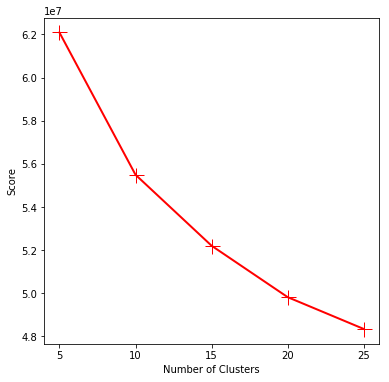

In [46]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# plot the results
fig, ax = plt.subplots(figsize=(6,6))

line = plt.plot(test_range, scores)
plt.setp(line, 'color', 'r', 'linewidth', 2.0, marker='+', ms=15.0)
ax.set_ylabel("Score")
ax.set_xlabel('Number of Clusters')
ax.set_xticks(test_range)
plt.show()



In [47]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# settle for 20 clusters

n_clusters = 20

# run k-means clustering on the data
kmean = KMeans(n_clusters, random_state=42)
cluster_labels = kmean.fit_predict(X_pca)
score = np.abs(kmean.score(X_pca))  
print(f"for {n_clusters} clusters, the score = {score}")


for 20 clusters, the score = 50073929.49965248


Data Distribution in clusters

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Number of points in each cluster 
[20686 43403 74555 48306 46845 47769 45376 56530 52192 49092 47008 45899
 67948 23199 32867  3337 43393 63760 54977 24079] 

Relative number of points in each cluster
 [ 0.02321085  0.0487006   0.0836549   0.05420204  0.05256272  0.0535995
  0.05091442  0.06342983  0.05856235  0.05508398  0.05274562  0.05150126
  0.07624147  0.02603058  0.03687862  0.0037443   0.04868938  0.0715423
  0.06168728  0.02701799] 


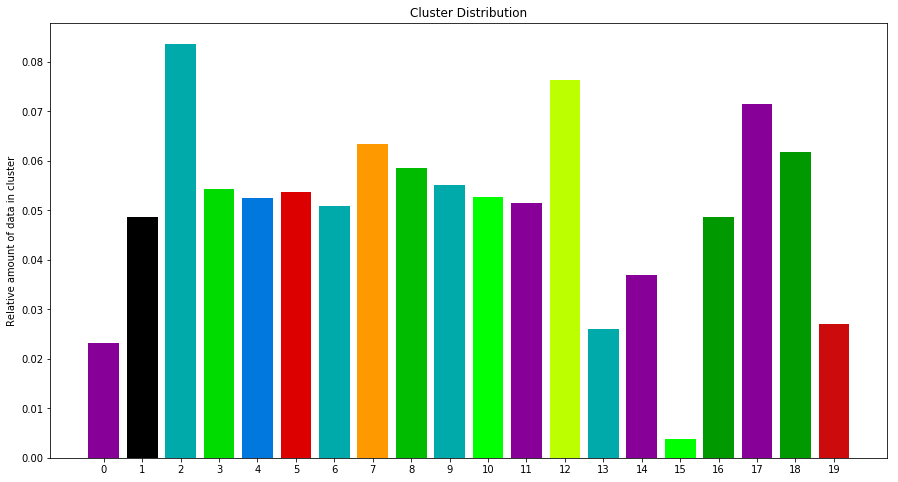

In [48]:
#calculate proportion in each cluster

unique, cluster_data_count = np.unique(cluster_labels, return_counts=True)
cluster_data_ratio = cluster_data_count/X_pca.shape[0]
print("Data Distribution in clusters\n")
print(unique)
print(f"\nNumber of points in each cluster \n{cluster_data_count} ")
print(f"\nRelative number of points in each cluster\n {cluster_data_ratio} ")

def cluster_distribution (unique, data, labels, n):
    fig, ax = plt.subplots(figsize=(15,8))
    colors = cm.nipy_spectral(labels.astype(float) / n)
    plt.bar(unique, data, color=colors)
    ax.set_ylabel('Relative amount of data in cluster')
    ax.set_title('Cluster Distribution')
    ax.set_xticks(unique)
    plt.show()
    
cluster_distribution(unique, cluster_data_ratio, cluster_labels, n_clusters)

### Discussion 3.1: Apply Clustering to General Population

I repeated the cluster analysis with the number of clusters increasing from 5 to 25. The line plot above shows that the the score is improving (decreasing) with the number of clusters but at a slower rate as the number of cluster increases.  I did not find a true "elbow" in that curve, but opted to continue the analysis with 20 clusters.  My rationale is that I don't see how a company would want to pigen-hole its customers in more than 20 categories.  And of course, 20 clusters makes the rest of the project relatively easier to complete!

NOTE:  I tried the silhouette score but ran into Memory problems.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [49]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [50]:
customers.shape

(191652, 85)

In [51]:
# recall feat_info
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=";")

Outliers dropped:  (191652, 79)


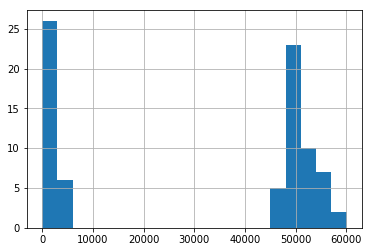

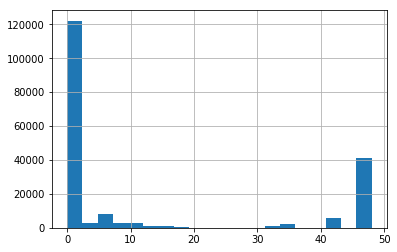

Dummied 'OST_WEST_KZ':  (191652, 79)
Dummied 6 multi-level categorial variables:  (191652, 114)
Removed redundant and dropped columns:  (191652, 101)
Replaced and dropped 'PRAEGENDE_JUGENDJAHRE':  (191652, 102)
Replaced and dropped 'CAMEO_INTL_2015' :  (191652, 103)


In [53]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
# Clean data
customers_go = clean_data(customers, outliers, cats_to_keep, cats_to_drop, wealth, life)

In [54]:
customers_go.shape

(191652, 103)

In [55]:
customers_imp = imp.fit_transform(customers_go)

#apply feature scaling
customers_scaled = scaler.fit_transform(customers_imp)

# apply PCA to customer data:
X_pca_customers = pca.transform(customers_scaled)

# clustering customer data
cluster_labels_customers = kmean.predict(X_pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Data Distribution in clusters(customer data) 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Number of points in each cluster 
[ 1585  7759 45691 10586 12914 12696  2454  3003  3135  3115 26444  6573
 10722  3959  4976   481  2075 12389 15914  5181] 

Relative number of points in each cluster
 [ 0.0082702   0.04048484  0.23840607  0.05523553  0.06738255  0.06624507
  0.01280446  0.01566903  0.01635777  0.01625342  0.13797925  0.03429654
  0.05594515  0.02065723  0.02596373  0.00250976  0.01082692  0.06464321
  0.08303592  0.02703337] 


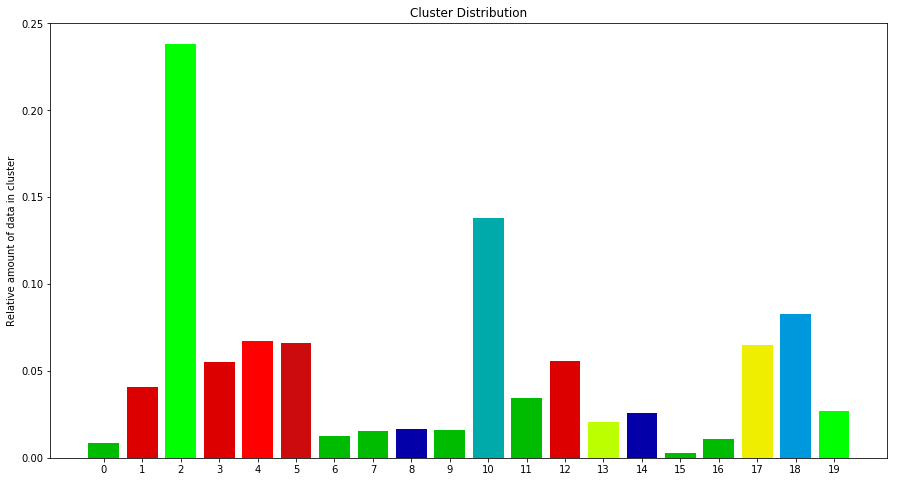

In [56]:
#calculate proportion in each cluster

#print(np.unique(cluster_labels_customers))
unique, cluster_data_count_customers = np.unique(cluster_labels_customers, return_counts=True)
cluster_data_ratio_customers = cluster_data_count_customers/X_pca_customers.shape[0]
print("Data Distribution in clusters(customer data) \n")
print(unique)
print(f"\nNumber of points in each cluster \n{cluster_data_count_customers} ")
print(f"\nRelative number of points in each cluster\n {cluster_data_ratio_customers} ")

cluster_distribution(unique, cluster_data_ratio_customers, cluster_labels_customers, n_clusters)

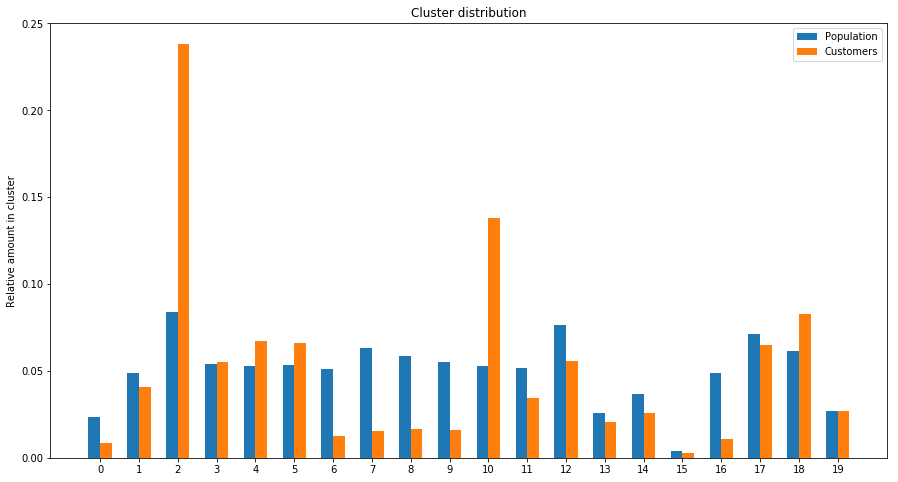

In [57]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

x = np.arange(len(unique)) 
width = 0.3  # the width of the bars
fig, ax = plt.subplots(figsize=(15,8))
pop = ax.bar(x - width/2, cluster_data_ratio, width, label='Population')
cust = ax.bar(x + width/2, cluster_data_ratio_customers, width, label='Customers')

ax.set_ylabel('Relative amount in cluster')
ax.set_title('Cluster distribution')
ax.set_xticks(unique)
ax.set_xticklabels(unique)
ax.legend()

(20, 103)
(20, 103)
Cluster number:  2

Weights after scaling
[-0.42470712  0.07513427 -0.04861746  0.81746693 -0.37416655  1.28734498
  1.45733745 -0.10490769 -0.4921028   0.96663549 -0.58773238 -0.36735828
 -0.19890116 -1.01696789  0.84617862  1.34329598  0.54987874 -1.39227724
  0.36145219 -0.76987121 -0.52218135  0.10851057  1.21191305  0.70482947
  0.79450811  0.50317818 -0.43015648 -0.0904755   0.90558099 -0.5857079
 -0.05897353 -1.24287679  0.9220485   0.53894253 -0.46175803 -0.10707193
 -1.1671506  -0.32121298 -0.45829786 -0.54583218 -0.88950248 -0.90792186
 -0.53616815 -0.39331702 -0.11159004  0.76169372  1.02601353  0.20095533
  0.2636322   0.21502927 -1.09720182 -0.26285191  0.72581216  1.64036882
 -0.23933682  0.24750025  0.38482382 -0.87159134 -0.6217635  -0.56545562
 -0.28239765  0.73753753 -0.10325716 -0.06413085 -0.21827783 -0.284715
 -0.26317261 -0.33427711 -0.22489745  1.3171355  -0.56826434 -0.35927443
 -0.2923568   2.44440283 -0.34542754 -0.69915723 -0.55890848 -0.1

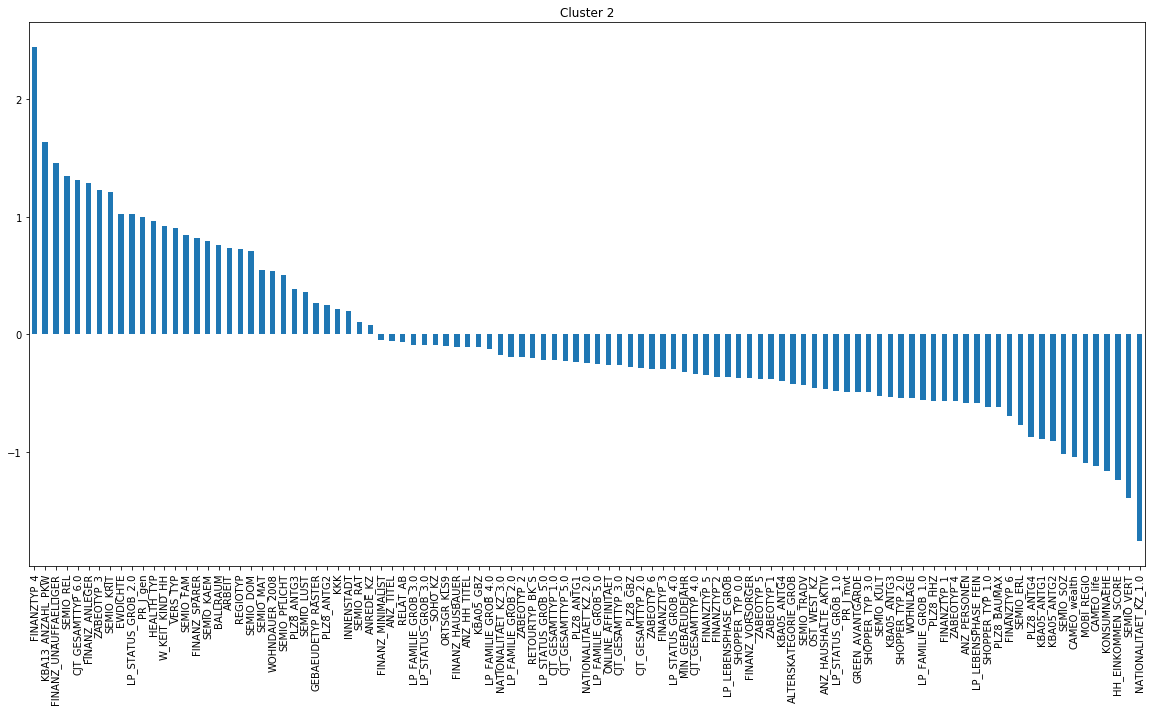

In [58]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Inverse the results
pca_to_scaler = pca.inverse_transform(kmean.cluster_centers_)
scaler_to_original = scaler.inverse_transform(pca_to_scaler)
print(scaler_to_original.shape)
print(pca_to_scaler.shape)

#Get details for a specific cluster

def cluster_data (cluster_id):
    print("Cluster number: ", cluster_id)
    print ("\nWeights after scaling")
    print(pca_to_scaler[cluster_id,:])
    print ("\nWeights before scaling")
    print(scaler_to_original[cluster_id,:])

    #Associate data to attributes
    cluster_info = pd.DataFrame(data=pca_to_scaler[cluster_id,:], index=azdias_go.columns, columns=['weight'])
    cluster_info.head()
    #sort the values
    cluster_info = cluster_info.sort_values(by='weight', axis=0, ascending=False)
    print(cluster_info)
    cluster_info.plot(kind='bar', figsize=(20,10), legend=False, title = "Cluster " + str(cluster_id))

cluster_id = 2
cluster_data(cluster_id)

Cluster number:  7

Weights after scaling
[ -8.38747015e-01   8.74340604e-01  -1.38444224e+00   1.09828398e+00
  -8.38261462e-01   9.07651298e-01   8.32913051e-01   6.27650132e-01
  -3.81602448e-01   1.85736236e-01  -6.60886513e-01  -5.92771385e-01
  -6.29378509e-01  -4.79786537e-01  -2.13446669e-01   4.45402746e-01
   3.41435044e-01  -8.11051625e-01  -3.93735977e-01  -1.16804388e-02
  -1.32152776e-01   1.13118760e+00   4.81643222e-01   7.74615415e-01
   7.20331417e-01   8.56674060e-01   9.02329955e-01  -2.67112017e-03
   9.71640623e-02  -3.25503718e-01  -4.57206678e-02   5.98217715e-01
   1.32207358e-01  -4.31688203e-01   2.38545517e-02  -6.16839735e-02
   3.42726065e-04  -2.80879441e-02  -2.49168166e-01  -2.21497803e-01
  -2.52866478e-01   5.37796516e-01   3.46822688e-01  -8.16528065e-02
  -1.92508103e-01   3.80586141e-02  -9.85309958e-03   1.00520842e-01
   3.48071205e-02  -7.47242303e-02  -1.85183802e-01   8.03160916e-02
  -7.27527461e-02   8.76588033e-02   9.38464164e-02   1.87613

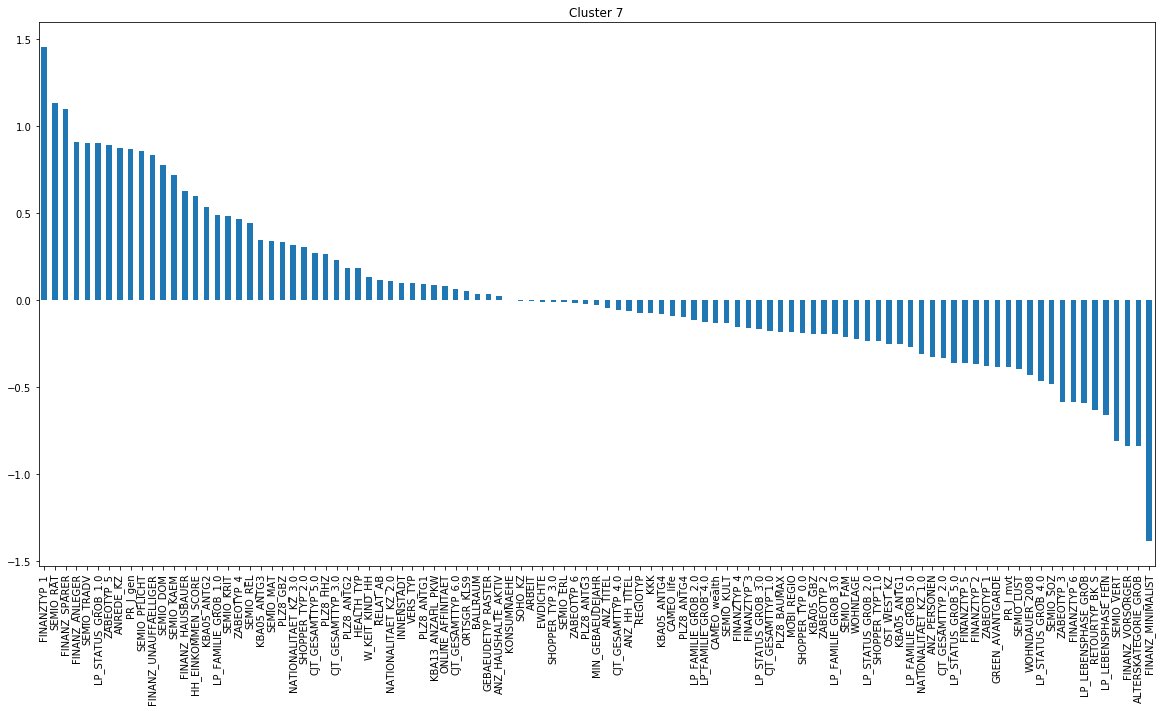

In [59]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_id = 7
cluster_data(cluster_id)

### Discussion 3.3: Compare Customer Data to Demographics Data

Customers are over-represented in **Cluster 2** compared to the general population. The bar chart above for this cluster shows that the individuals in this category are financially astute (FINANZTYP_4, FINANZ_UNAUFFAELLIGER, FINANZ_ANLEGER)--probably conservative investors--and personally religious.  The strongest negative weights seem to corroborate the story: LP_STATUS_GROB_1.0, GREEN_AVANTGARDE describe low-income, environmentalist part of the population. 



In contrast, customers are under-represented in **Cluster 7** compared to the general population. The bar chart above shows the highest weights for FINANZTYP_1, LP_STATUS_GROB_1.0, FINANZ_SPARER, i.e., single people, low income, savers.  This is actually consistent with the findings of Cluster 2: The characteristics that make customers over-represented in one cluster should be the opposite of those making them in a cluster where they are under-represented compared to the general population.  There a few more clusters where the customers are under-represented, e.g., 8, 9, 16, which might warrant further investigation.



The findings outline above would indicate that the company's customers are more affluent than the average--or have the life style of the more affluent part of the population.  The company seems to be less popular with both younger people and older ones--the common thread being that youngest and oldest have comparatively less money that adults with an established careers. 

In conclusion, I think the primary difference between this company's customers and non-customers is their level of wealth and interest in financial matters.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.